# Mandatory Assignment - 2

Information:
* The dataset used in this assignment is retrieved from kaggle.com, full link below:
  - https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
- 
* NOTE: GPT is used partially,
    - As an assistent to improve the visual quality of the plotting.
    - NameError checking
    - Some name refactoring.
  

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_curve, auc

In [2]:
#Supplmententary to make repo indepentent.
# Get the current notebook's directory
current_dir = os.getcwd()
# Build the path to the sibling "Files" folder
file_path = os.path.join(current_dir, "files", "BC_diag.csv")
print("Path buildt is : \n", file_path)
print("Does the file exists? -> ", os.path.exists(file_path))

Path buildt is : 
 C:\Users\sebtk\NTNU - IKKE ONEDRIVE SYNC\notebookFiles\Machine_Learning_Jupyter_Notebook\files\BC_diag.csv
Does the file exists? ->  True


In [3]:
dframe = pd.read_csv(file_path)
dframe["diagnosis"] = dframe["diagnosis"].map({"M": 1, "B": 0}) #Remapping the data into INTs
dframe = dframe.drop(columns=['Unnamed: 32']) #Removing indexed csv addon. (Contains no data)
dframe.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
subsetToShowFeatureSetup = dframe[["radius_mean","radius_se","radius_worst"]]
subsetToShowFeatureSetup.describe()

,radius_mean,radius_se,radius_worst
count,569.000000,569.000000,569.000000
mean,14.127292,0.405172,16.269190
std,3.524049,0.277313,4.833242
min,6.981000,0.111500,7.930000
25%,11.700000,0.232400,13.010000
50%,13.370000,0.324200,14.970000
75%,15.780000,0.478900,18.790000
max,28.110000,2.873000,36.040000


# Exercice-1: Data Preparation:
#### Q-1.1 Load the dataset, inspect feature names and target distribution. Comment on
 dataset imbalance.

 At first glance we can see a clear variance across the values in each category.
 Inspecting the feature names tells us that values like radius_mean also has a radius standard error(SE) worst radius. Its also worth noting that the dataset has a imbalance of 357 benign against 212 malignant, BUT have stamped each data entry with the M/B value, which we can use to create classes later on. 

**PLEASE NOTE**: The data set contains a diagnosis field with Benign(B) and Malignant(M), for easier use this is translated to the binary boolean correspondant, where M = 1, & B = 0.

#### Q-1.2 Analyze all features with and without standardization (i.e., zero mean and unit
 variance). Plot the feature analysis with and without standardization and decide
 which version is more suitable.

In [5]:
scaler = StandardScaler()

df_rm_diag = dframe.drop(columns=["diagnosis", "id"])
df_diag_id = dframe[["diagnosis","id"]]

df_scaled = scaler.fit_transform(df_rm_diag)

df_scaled = pd.DataFrame(df_scaled, columns=df_rm_diag.columns)

# Reattach diagnosis and id:
df_scaled_full = pd.concat([df_scaled, df_diag_id.reset_index(drop=True)], axis=1)


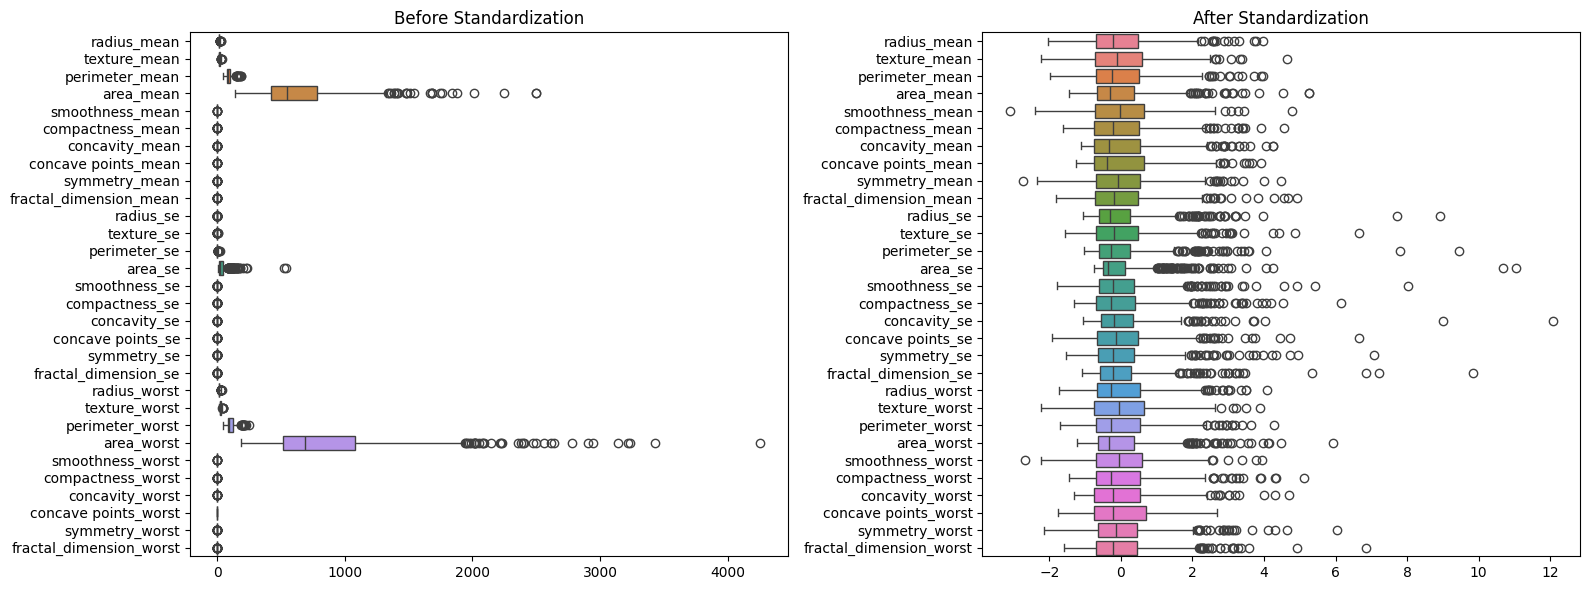

In [6]:
# Drop target/id for plotting
X = dframe.drop(columns=["diagnosis", "id"])
X_scaled = df_scaled  # already scaled version

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

sns.boxplot(data=X, orient="h", ax=axes[0])
axes[0].set_title("Before Standardization")

sns.boxplot(data=X_scaled, orient="h", ax=axes[1])
axes[1].set_title("After Standardization")

plt.tight_layout()
plt.show() #Box and whiskers plot.

#### Q-1.2 COMMENT
The Box and Whisker plot above:
left of box split = 25%
Line inside box = Median (50th percentile)
Whiskers = Within 1.5 x IQR from the box
Circles outside of whiskers = outlier values.

Here the standardScaler method turns our dataset range from  ca. 0->4500 into ca. -3->13 which as seen above creates a much better flow between each of our features.

#### Q-1.3 Comment on importance of three way split with respect to hyperparameter search and robustness of any learned model.

When it comes to model training & evaluation it is important to use disiplins as three-way split which is an addition to the two-way split, where we also have an unbiased check from the test set, 
Three-way split:
* Training set
  - Here the model learns the patterns of the data.
* Validation set (Or cross-validation)
  - Here we can generalise the data with tuning.
* Test set
  - Our new, unbiased check.
 
A good practice when using hyperparameter search is to NOT use the test set, but the validation set, doing the opposite is the same as doing a math test while having the answer sheet infront of you. By using the validation set instead, we do not risk contamination on the test set, and our final measure of generalization does not become artifical which makes it more robust.


# Exercice-2: Decision Trees

#### **Q-2.1** Train a Decision Tree classifier using default parameters.  
- Evaluate it on validation
 sets from original splits (report accuracy mean and std).

In [7]:
#Retrieving main values:
x_features = df_scaled_full.drop(columns=["diagnosis", "id"])
y_target = df_scaled_full["diagnosis"]
#Creating three-way split in to splits:
x_training, x_tmp, y_training, y_tmp = train_test_split(
    x_features,y_target,
    test_size=0.4, random_state=42, stratify=y_target #Stratify makes the propoertions of Malignent and Benign "the same" on each split
)

x_val, x_test, y_val, y_test = train_test_split(
    x_tmp,y_tmp,
    test_size=0.5, random_state=42, stratify=y_tmp)

print("X 2D -> Train:", x_training.shape, "Validation:", x_val.shape, "Test:", x_test.shape)
print("Y 1D -> Train:", y_training.shape, "Validation:", y_val.shape, "Test:", y_test.shape)

X 2D -> Train: (341, 30) Validation: (114, 30) Test: (114, 30)
Y 1D -> Train: (341,) Validation: (114,) Test: (114,)


In [8]:
# Our classifier:
tree_classifier = DecisionTreeClassifier(random_state = 42)

#Cross Validation setup, using 5-fold Stratified CV:
cv_stratified_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

val_scores = [] 

for train_index, val_index in cv_stratified_5fold.split(x_training, y_training):
    x_tr, x_val = x_training.iloc[train_index], x_training.iloc[val_index]
    y_tr, y_val = y_training.iloc[train_index], y_training.iloc[val_index]
    
    tree_classifier.fit(x_tr, y_tr)
    prediction =tree_classifier.predict(x_val)
    accuracy = accuracy_score(y_val, prediction)
    val_scores.append(accuracy)

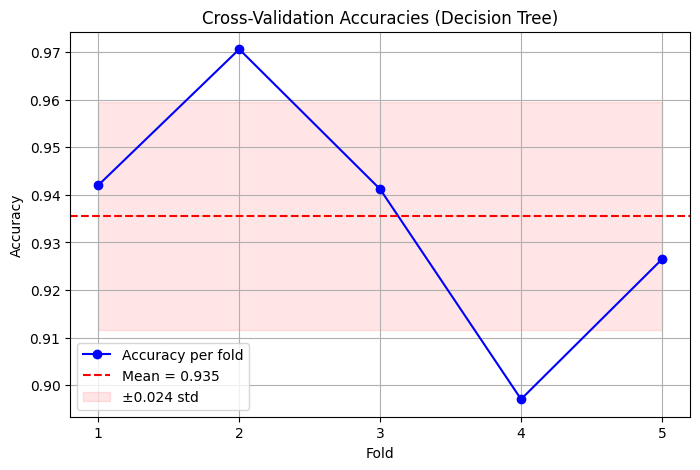

Mean accuracy: 0.935464620630861
Std deviation: 0.02393859767366921


In [9]:
#PLOTTING:
# Plot validation accuracies across folds
plt.figure(figsize=(8,5))
plt.plot(range(1, len(val_scores)+1), val_scores, marker='o', linestyle='-', color='b', label='Accuracy per fold')
plt.axhline(np.mean(val_scores), color='r', linestyle='--', label=f'Mean = {np.mean(val_scores):.3f}')
plt.fill_between(range(1, len(val_scores)+1),
                 np.mean(val_scores)-np.std(val_scores),
                 np.mean(val_scores)+np.std(val_scores),
                 color='r', alpha=0.1, label='±0.024 std')

plt.title("Cross-Validation Accuracies (Decision Tree)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(val_scores)+1))
plt.legend()
plt.grid(True)
plt.show()

# Extra data:
mean_acc = np.mean(val_scores)
std_acc = np.std(val_scores)


print("Mean accuracy:", mean_acc)
print("Std deviation:", std_acc)


#### **Q-2.2** From the trained model, comment on feature importance values and identify the
 top 3 features from your model.

In [10]:
importances = tree_classifier.feature_importances_
feature_importance = pd.DataFrame({"Feature": x_training.columns,
                                   "Importance":importances}).sort_values(by="Importance", ascending=False)
print("TOP 5 FEATURES: ")
print(feature_importance.head(5)) #TOP 5

TOP 5 FEATURES: 
                 Feature  Importance
22       perimeter_worst    0.716189
27  concave points_worst    0.123031
21         texture_worst    0.045443
6         concavity_mean    0.031443
28        symmetry_worst    0.027130


#### **Q-22 COMMENT**
Here we can see how our top 4 values are "worst" features which makes sense since our decision tree classifier splits data at threshold values, which is found naturaly as a worst-case.

#### **Q-2.3** Vary the max depth parameter (e.g., depth 2-10). Use validation accuracy (mean
 ± std from cross-validation on the training set) to choose the best depth. Provide
 performance for each chosen depth (at-least 5 to be reported) and discuss the aspects
 of overfitting vs. underfitting.

In [11]:
depths = range(2, 15)  # depths 2–10

mean_scores = []
std_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(clf, x_training, y_training, cv=cv_stratified_5fold, scoring="accuracy")
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())


mean_scores = np.array(mean_scores)
std_scores = np.array(std_scores)


best_idx = np.lexsort((std_scores, -mean_scores))  # sort by -mean, then std
best_idx = best_idx[0]  # take the first one

best_max_depth = depths[best_idx]
best_mean = mean_scores[best_idx]
best_std = std_scores[best_idx]


print(f"Best depth = {best_max_depth}, Mean = {best_mean:.3f}, Std = {best_std:.3f}")

Best depth = 8, Mean = 0.935, Std = 0.024


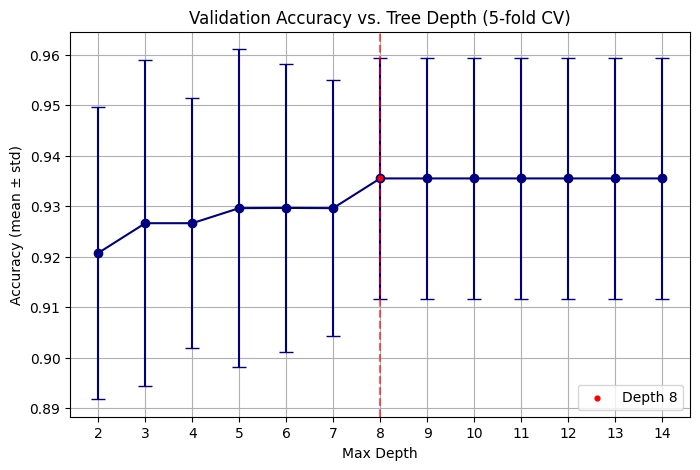

In [12]:
plt.figure(figsize=(8,5))
plt.errorbar(depths, mean_scores, yerr=std_scores, fmt='-o', capsize=5, color="navy")

# Highlight depth = 8 specifically
highlight_depth = 8
highlight_idx = depths.index(highlight_depth)
plt.scatter(highlight_depth, mean_scores[highlight_idx], 
            color="red", s=12, zorder=5, label=f"Depth {highlight_depth}")
plt.axvline(highlight_depth, color="red", linestyle="--", alpha=0.6)

plt.title("Validation Accuracy vs. Tree Depth (5-fold CV)")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy (mean ± std)")
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

#### **Q-2.3 COMMENT** 
Here we can see the how the mean value grows until it has reached the max depth of 8, where it stagnates.

Though a higher max depth leads to a higher risk of overfitting, having one thats to low can create a bigger risk of underfitting which can be seen in the graf above; it is also worth noting that stopping the max depth value when the mean value stagnates is a clever way to stop unnecessary overfitting since a high max depth makes small changes in the dataset explode onto the decision tree.

#### **Q-2.4**  Repeat previous exercise with different *min_samples_leaf* values.  
Which setting generalizes best according to the validation set?

In [13]:
min_sample_leaf_range = range(1, 20)  # skips 2.

mean_scores_dt_leaf = []
std_scores_dt_leaf = []

for min_sample_leaf in min_sample_leaf_range:
    clf = DecisionTreeClassifier(min_samples_leaf=min_sample_leaf, max_depth=best_max_depth, random_state=42) #Uses max depth 8, as found in last task.
    scores = cross_val_score(clf, x_training, y_training, cv=cv_stratified_5fold, scoring="accuracy")
    mean_scores_dt_leaf.append(scores.mean())
    std_scores_dt_leaf.append(scores.std())


mean_scores = np.array(mean_scores_dt_leaf) #Needed for lexsort
std_scores = np.array(std_scores_dt_leaf) #---


best_idx = np.lexsort((std_scores, -mean_scores))  # sort by -mean, then std
best_idx = best_idx[0]  # First elem

best_min_sample = min_sample_leaf_range[best_idx]
best_mean = mean_scores[best_idx]
best_std = std_scores[best_idx]

print(f"Best minimum sample leaf = {best_min_sample}, Mean = {best_mean:.3f}, Std = {best_std:.3f}")

Best minimum sample leaf = 3, Mean = 0.944, Std = 0.029


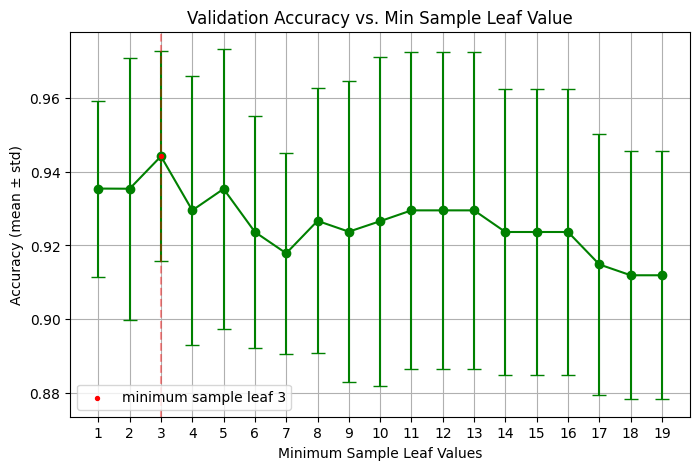

In [14]:
plt.figure(figsize=(8,5))
plt.errorbar(min_sample_leaf_range, mean_scores_dt_leaf, yerr=std_scores_dt_leaf, fmt='-o', capsize=5, color="green")

# Highlight depth = 8 specifically
highlight_leaf = min_sample_leaf_range[best_idx]
highlight_idx = min_sample_leaf_range.index(highlight_leaf)


plt.scatter(highlight_leaf, mean_scores_dt_leaf[highlight_idx], 
            color="red", s=8, zorder=5, label=f"minimum sample leaf {highlight_leaf}")
plt.axvline(highlight_leaf, color="red", linestyle="--", alpha=0.4)

plt.title("Validation Accuracy vs. Min Sample Leaf Value")
plt.xlabel("Minimum Sample Leaf Values")
plt.ylabel("Accuracy (mean ± std)")
plt.xticks(min_sample_leaf_range)
plt.legend()
plt.grid(True)
plt.show()

#### **Q-2.4 COMMENT**
According to the graf above, a *minimum sample leaf* of the value **3**, combined with a *maximum depth* of **8** gives us a shocking accuracy score of above **94%**, making it the best *min_sample_leaf* value.

# Exercice-3 Support Vector Machines (SVM)

#### Q-3.1 Train a linear SVM (kernel="linear") and evaluate on validation sets (use the original 5 splits that was created in previous exercise). Report accuracy mean, std and plot the ROC for each split.

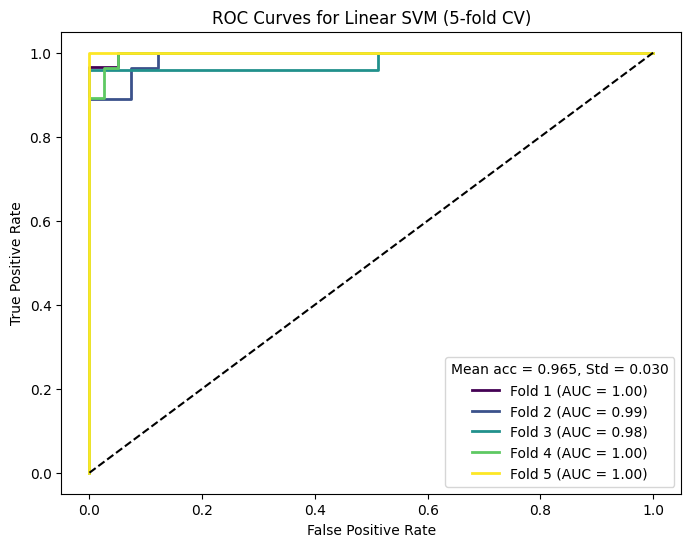

Mean accuracy: 0.935464620630861
Std deviation: 0.02393859767366921


In [15]:


# Our classifier:
svm_classifier = SVC(kernel="linear", probability=True, random_state=42)

#New CV, so we have Kfold, and not Stratified Kfold
cv_5fold =KFold(n_splits=5, shuffle=True, random_state=42)
#Init score arrays
val_scores_acc = []

colors = plt.cm.viridis(np.linspace(0,1, cv_5fold.get_n_splits())) #A small improvement to the ROC Curve's colours.
plt.figure(figsize=(8,6)) #Start plotting scheme

#K-Fold:
for i, (train_index, val_index) in enumerate(cv_5fold.split(x_training, y_training)):
    x_tr, x_val = x_training.iloc[train_index], x_training.iloc[val_index]
    y_tr, y_val = y_training.iloc[train_index], y_training.iloc[val_index]
    
    svm_classifier.fit(x_tr, y_tr)
    y_pred_svm = svm_classifier.predict(x_val)
    #Accuracy:
    val_scores_acc.append(accuracy_score(y_val, y_pred_svm))
   
    
    
    #ROC curve:
    y_proba = svm_classifier.predict_proba(x_val)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr,tpr)

    #Graf improvement, using better colours:
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f"Fold {i+1} (AUC = {roc_auc:.2f})")

# Compute mean and std accuracy
mean_acc_linear = np.mean(val_scores_acc)
std_acc_linear = np.std(val_scores_acc)

#Plot legend and optimizing:
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Linear SVM (5-fold CV)")

# Add mean/std accuracy as a legend entry
plt.legend(title=f"Mean acc = {mean_acc_linear:.3f}, Std = {std_acc_linear:.3f}")
plt.show()

print("Mean accuracy:", mean_acc)
print("Std deviation:", std_acc)


#### Q3.2  
#### Train an Radial Basis Function (RBF) kernel SVM. Compare its performance to the linear kernel using validation accuracy. Plot ROC for these models.

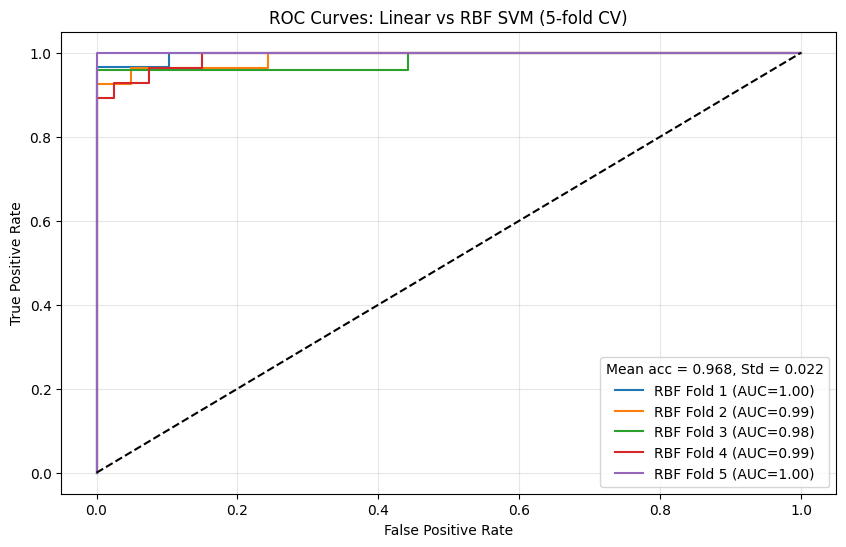

In [16]:
#classifier with new kernel:
svm_rbf = SVC(kernel="rbf", probability=True, random_state=42)

#Using CV from before.

#Score array
val_scores_rbf = []

plt.figure(figsize=(10,6))

for i, (train_index, val_index) in enumerate(cv_5fold.split(x_training, y_training), 1):
    x_tr, x_val = x_training.iloc[train_index], x_training.iloc[val_index]
    y_tr, y_val = y_training.iloc[train_index], y_training.iloc[val_index]

    svm_rbf.fit(x_tr, y_tr)

    y_pred_rbf = svm_rbf.predict(x_val)
    val_scores_rbf.append(accuracy_score(y_val, y_pred_rbf))
    
    y_proba_rbf = svm_rbf.predict_proba(x_val)[:,1]
    fpr_rbf, tpr_rbf, _ = roc_curve(y_val, y_proba_rbf)
    roc_auc_rbf = auc(fpr_rbf, tpr_rbf)
    plt.plot(fpr_rbf, tpr_rbf,
             label=f"RBF Fold {i} (AUC={roc_auc_rbf:.2f})")

# Compute mean and std accuracy
mean_acc_rbf = np.mean(val_scores_rbf)
std_acc_rbf = np.std(val_scores_rbf)

#Plot legend and optimizing:
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Linear vs RBF SVM (5-fold CV)")
plt.legend()
plt.grid(alpha=0.3)

# Add mean/std accuracy as a legend entry
plt.legend(title=f"Mean acc = {mean_acc_rbf:.3f}, Std = {std_acc_rbf:.3f}")
plt.show()



#### Q3.2 COMMENT:
Here we can see a slight increace in Mean accuracy, **from 0.965 to 0.968**, and a **standard deviation reduction of 0.08 points**. (From 0.030 to 0.022)

#### Q3.3 Experiment with different values of C (regularization strength). Use the validation set to select the best C. Report results as a plot of accuracy vs. C.

In [17]:
#classifier with new kernel:
# -> svm_rbf = SVC(kernel="rbf", probability=True, random_state=42), will be interated through with:

#Using CV from before:

#Score arrays:
mean_accuracies_C_adjustment = []
std_accuracies_C_adjustment = []

c_values = np.arange(0.1,1.5,0.1) #First ran with  [0.01, 0.1, 1, 10, 50], then repeated with more more numbers around the best scorign (1)

for C in c_values:
    svm_rbf = SVC(kernel="rbf", C=C, probability=True, random_state=42)
    fold_accuracies = []
    
    for train_index, val_index in cv_5fold.split(x_training, y_training):
        x_tr, x_val = x_training.iloc[train_index], x_training.iloc[val_index]
        y_tr, y_val = y_training.iloc[train_index], y_training.iloc[val_index]
        
        svm_rbf.fit(x_tr, y_tr)
        y_pred = svm_rbf.predict(x_val)
        fold_accuracies.append(accuracy_score(y_val, y_pred))
    
    mean_accuracies_C_adjustment.append(np.mean(fold_accuracies))
    std_accuracies_C_adjustment.append(np.std(fold_accuracies))

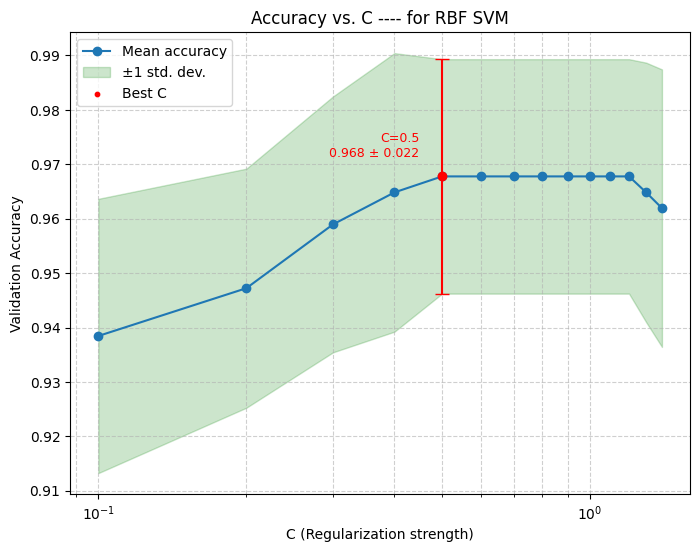

Best C: 0.5, with mean validation accuracy of 0.968 and std of 0.022


In [18]:
plt.figure(figsize=(8,6))

mean_accuracies = np.array(mean_accuracies_C_adjustment)
std_accuracies = np.array(std_accuracies_C_adjustment)

# Plot mean accuracy curve
plt.semilogx(c_values, mean_accuracies, marker='o', linestyle='-', label="Mean accuracy")

# Shaded ±1 std band
plt.fill_between(c_values,
                 mean_accuracies - std_accuracies,
                 mean_accuracies + std_accuracies,
                 color='green', alpha=0.2, label="±1 std. dev.")

# Find best C
bestC_index = np.argmax(mean_accuracies)
best_C = c_values[bestC_index]
best_acc_mean = mean_accuracies[bestC_index]
best_acc_std = std_accuracies[bestC_index]

# Highlight best C point
plt.scatter(best_C, best_acc_mean, color='red', s=10, zorder=5, label="Best C")
plt.errorbar(best_C, best_acc_mean, yerr=best_acc_std, fmt='o', color='red', capsize=5)

# Annotate text to the LEFT and a little ABOVE the point
plt.text(best_C * 0.9,                # shift left (multiply by <1)
         best_acc_mean + 0.003,       # shift upward
         f"C={best_C}\n{best_acc_mean:.3f} ± {best_acc_std:.3f}",
         ha='right', va='bottom', fontsize=9, color='red')
# Labels and formatting
plt.xlabel("C (Regularization strength)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs. C ---- for RBF SVM")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()

print(f"Best C: {best_C}, with mean validation accuracy of {best_acc_mean:.3f} and std of {best_acc_std:.3f}")

#### Q3.4 Experiment with different γ values for the RBF kernel. Discuss the effect on bias variance trade-off for all experimented values. Select the best γ using the validation set and report the performance on validation set.

In [19]:
#Using CV, and the best C value found from before.
#Score arrays:
best_C = best_C ##JUST TO SHOW, value is from the task above.

mean_accuracies_gamma_adjustment = []
std_accuracies_gamma_adjustment = []

gamma_range = np.logspace(-3,2,20) # Logarithmic values from 10e-3 to 10e2

for gamma_current in gamma_range:
    svm_rbf = SVC(kernel="rbf", C=best_C, gamma=gamma_current, probability=True, random_state=42)
    fold_accuracies = []
    
    for train_index, val_index in cv_5fold.split(x_training, y_training):
        x_tr, x_val = x_training.iloc[train_index], x_training.iloc[val_index]
        y_tr, y_val = y_training.iloc[train_index], y_training.iloc[val_index]
        
        svm_rbf.fit(x_tr, y_tr)
        y_pred = svm_rbf.predict(x_val)
        fold_accuracies.append(accuracy_score(y_val, y_pred))
    
    mean_accuracies_gamma_adjustment.append(np.mean(fold_accuracies))
    std_accuracies_gamma_adjustment.append(np.std(fold_accuracies))

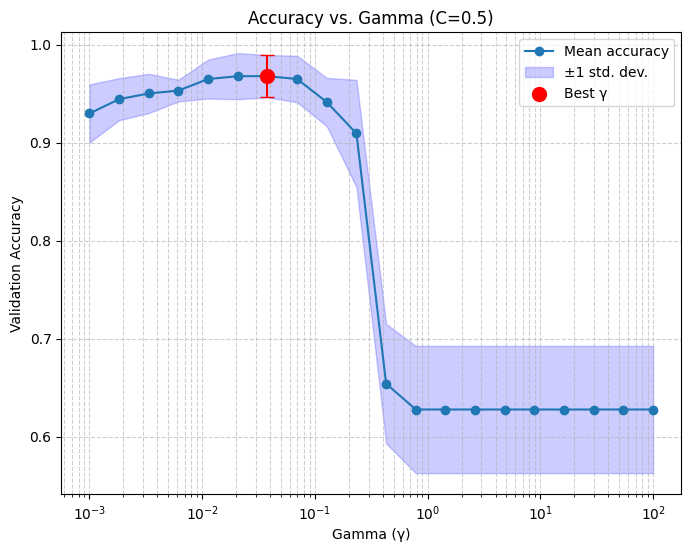

Best γ: 0.0379, with mean accuracy 0.968 ± 0.022


In [20]:
mean_accuracies = np.array(mean_accuracies_gamma_adjustment)
std_accuracies = np.array(std_accuracies_gamma_adjustment)

plt.figure(figsize=(8,6))
plt.semilogx(gamma_range, mean_accuracies, marker='o', linestyle='-', label="Mean accuracy")
plt.fill_between(gamma_range,
                 mean_accuracies - std_accuracies,
                 mean_accuracies + std_accuracies,
                 color='blue', alpha=0.2, label="±1 std. dev.")

best_idx = np.argmax(mean_accuracies)
best_gamma = gamma_range[best_idx]

plt.scatter(best_gamma, mean_accuracies[best_idx], color='red', s=100, zorder=5, label="Best γ")
plt.errorbar(best_gamma, mean_accuracies[best_idx], yerr=std_accuracies[best_idx],
             fmt='o', color='red', capsize=5)

plt.xlabel("Gamma (γ)")
plt.ylabel("Validation Accuracy")
plt.title(f"Accuracy vs. Gamma (C={best_C})")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()

print(f"Best γ: {best_gamma:.4f}, with mean accuracy {mean_accuracies[best_idx]:.3f} ± {std_accuracies[best_idx]:.3f}")

In [21]:
#Testing again with closer scope (same code, but gamma_range is MUCH tighter):
mean_accuracies_gamma_adjust = []
std_accuracies_gamma_adjust = []

gamma_range = np.logspace(-2,-1,20) # Logarithmic values from 10e-3 to 10e2

for gamma_current in gamma_range:
    svm_rbf = SVC(kernel="rbf", C=best_C, gamma=gamma_current, probability=True, random_state=42)
    fold_accuracies = []
    
    for train_index, val_index in cv_5fold.split(x_training, y_training):
        x_tr, x_val = x_training.iloc[train_index], x_training.iloc[val_index]
        y_tr, y_val = y_training.iloc[train_index], y_training.iloc[val_index]
        
        svm_rbf.fit(x_tr, y_tr)
        y_pred = svm_rbf.predict(x_val)
        fold_accuracies.append(accuracy_score(y_val, y_pred))
    
    mean_accuracies_gamma_adjust.append(np.mean(fold_accuracies))
    std_accuracies_gamma_adjust.append(np.std(fold_accuracies))

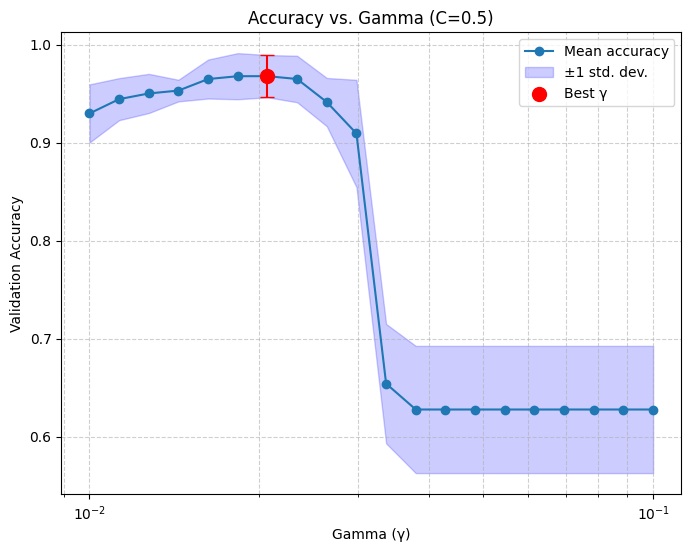

Best γ: 0.0207, with mean accuracy 0.968 ± 0.022


In [22]:
mean_accuracies = np.array(mean_accuracies_gamma_adjustment)
std_accuracies = np.array(std_accuracies_gamma_adjustment)

plt.figure(figsize=(8,6))
plt.semilogx(gamma_range, mean_accuracies, marker='o', linestyle='-', label="Mean accuracy")
plt.fill_between(gamma_range,
                 mean_accuracies - std_accuracies,
                 mean_accuracies + std_accuracies,
                 color='blue', alpha=0.2, label="±1 std. dev.")

best_idx = np.argmax(mean_accuracies)
best_gamma = gamma_range[best_idx]

plt.scatter(best_gamma, mean_accuracies[best_idx], color='red', s=100, zorder=5, label="Best γ")
plt.errorbar(best_gamma, mean_accuracies[best_idx], yerr=std_accuracies[best_idx],
             fmt='o', color='red', capsize=5)

plt.xlabel("Gamma (γ)")
plt.ylabel("Validation Accuracy")
plt.title(f"Accuracy vs. Gamma (C={best_C})")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()

print(f"Best γ: {best_gamma:.4f}, with mean accuracy {mean_accuracies[best_idx]:.3f} ± {std_accuracies[best_idx]:.3f}")

#### Q3.4 : Discuss the effect on bias variance trade-off for all experimented values. Select the best γ using the validation set and report the performance on validation set.
#### COMMENT:
In theory, having a low regularization (C) will give low bias and high variance, with the same effect happening from a low gamma. In task 3.3 and 3.4 we can see how the optimal C and gamma value is followed by either a stagnating value or a drastic drop in mean accurazy, were the standard deviation grows for each step.

For our model, what we want is low bias and low variance, but the tradeoff we make is that a lower bias has the cost of a higher variance. In the coode above the C value is found before gamma, if we had tried to find optimal gamma and then used that value when we find optimal C the values would most likely not match up with those we have now. 

# Exercice-4: Model Comparison

## Q-4.1 Compare Decision Tree and SVM results from the training set (cross-validation mean ± std) and validation set. Plot the performance comparison plots (e.g., scatter plots, ROC curves). Which model generalizes better?

In [23]:

# Running an Decision tree training with optimized params:
# CV used: cv_stratified_5fold 

decisionTree_optimized_acc = []  # List to collect 5 fold scores

# Classifier with optimized min_leaf and max_depth
clf = DecisionTreeClassifier(min_samples_leaf=best_min_sample, 
                             max_depth=best_max_depth, 
                             random_state=42)

# --- Cross-Validation Loop ---
for train_index, val_index in cv_stratified_5fold.split(x_training, y_training):
    # Data splitting
    x_tr, x_val = x_training.iloc[train_index], x_training.iloc[val_index]
    y_tr, y_val = y_training.iloc[train_index], y_training.iloc[val_index]
        
    # CRITICAL FIX: Train the Decision Tree classifier (clf)
    clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_val) # Predict using the Decision Tree

    # Append the Decision Tree's accuracy score
    acc = accuracy_score(y_val, y_pred)
    decisionTree_optimized_acc.append(acc)  


decisionTree_optimized_mean = np.mean(decisionTree_optimized_acc)
decisionTree_optimized_std = np.std(decisionTree_optimized_acc)
print("Decision Tree optimized complete")

Decision Tree optimized complete


In [24]:
svm_optimized_acc = [] 

# Classifier with optimized C and Gamma
svm_rbf = SVC(kernel="rbf", C=best_C, gamma=best_gamma, random_state=42)

# --- Cross-Validation Loop ---
for train_index, val_index in cv_5fold.split(x_training, y_training):
    # Data splitting
    x_tr, x_val = x_training.iloc[train_index], x_training.iloc[val_index]
    y_tr, y_val = y_training.iloc[train_index], y_training.iloc[val_index]
        
    # Train, Predict, and accuracy:
    svm_rbf.fit(x_tr, y_tr)
    y_pred = svm_rbf.predict(x_val)

    svm_optimized_acc.append(accuracy_score(y_val, y_pred)) 

svm_optimized_mean = np.mean(svm_optimized_acc) 
svm_optimized_std = np.std(svm_optimized_acc)   
print("SVM optimized complete")

SVM optimized complete


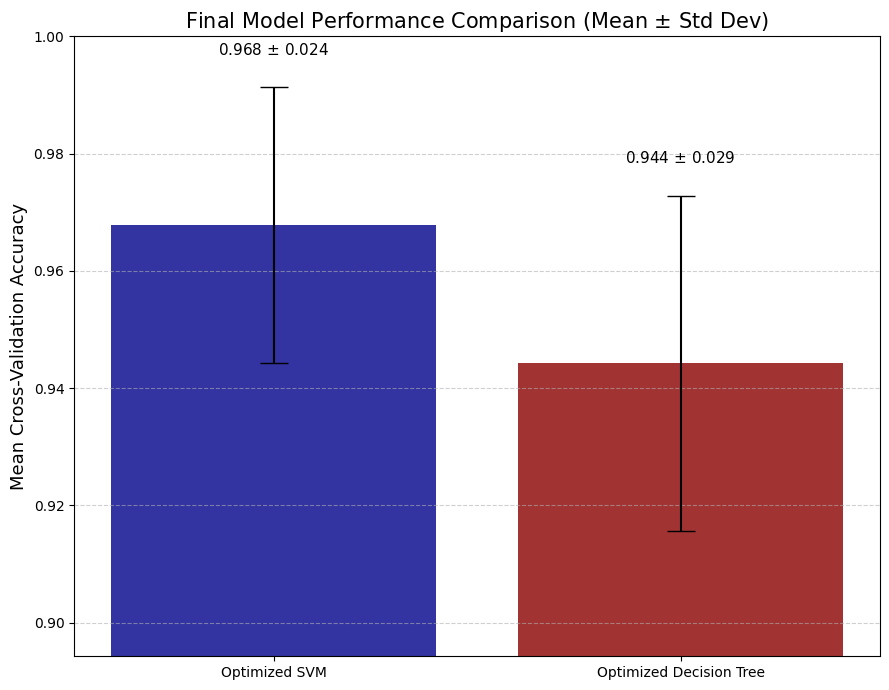

In [25]:
models = ['Optimized SVM', 'Optimized Decision Tree']
mean_scores = [svm_optimized_mean, decisionTree_optimized_mean]
std_devs = [svm_optimized_std, decisionTree_optimized_std]

# --- 2. Plotting Code ---
plt.figure(figsize=(9, 7))

# Bar plot with error bars for standard deviation
bars = plt.bar(models, mean_scores, yerr=std_devs, capsize=10, 
               color=['darkblue', 'darkred'], alpha=0.8)

# Add text labels for mean and std dev above the bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + std_devs[i] + 0.005, 
             f'{yval:.3f} $\\pm$ {std_devs[i]:.3f}', 
             ha='center', va='bottom', fontsize=11)

plt.title('Final Model Performance Comparison (Mean $\\pm$ Std Dev)', fontsize=15)
plt.ylabel('Mean Cross-Validation Accuracy', fontsize=13)
# Set a y-limit for fair comparison
plt.ylim(min(mean_scores) - 0.05, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Q4.1 COMMENT:
SVM has better generalization with both a higher mean and lower standard deviation.

### Q4.2 Discuss the trade-off between usability and accuracy for this dataset. Which model would you recommend for a medical decision-support system, and why? 

#### SVM:
- High accuracy
- Usability is low due to the black box type, which also makes it harder to interpret.
#### Decision Tree
- Still a high accuracy, but not as good as the SVM. 
- Usability is high since the decision logic can be visualized and mapped to a set of simple rules.
#### Medical decision-support system:
Decision Tree wins because the high usability, and transparancy is worth the loss of mean accuracy.



### Q4.3 Use GridSearchCV with the training set to tune hyperparameters for both Decision Trees and SVMs. Confirm your final choice with the validation set. Summarize the best settings and provide relevant performance plots.

In [26]:
from sklearn.model_selection import GridSearchCV

# Grid of parameters to search:
dt_param_grid = {
    'max_depth': np.arange(1, 20), # 
    'min_samples_leaf': np.arange(1, 10), # Typically look for small integers
    'criterion': ['gini', 'entropy']
}
# Init:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_grid_search = GridSearchCV(
    dt_clf, 
    dt_param_grid, 
    cv=cv_5fold,
    scoring='accuracy', 
    n_jobs=-1, # Use all available cores?? -> 
    verbose=1 # Creates a printOut of from param grid
)

# Fit:
dt_grid_search.fit(x_test, y_test)

# Retrieve accuracy:
best_dt_params = dt_grid_search.best_params_
mean_dt_optimized_score = dt_grid_search.best_score_

best_index = dt_grid_search.best_index_
std_dt_optimized_score = dt_grid_search.cv_results_["std_test_score"][best_index]

print(best_dt_params)
print(mean_dt_optimized_score)
print(std_dt_optimized_score)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
{'criterion': 'gini', 'max_depth': np.int64(2), 'min_samples_leaf': np.int64(1)}
0.9304347826086957
0.07064381221422573


In [27]:

# Grid of parameters to search:
svm_param_grid = {
    'C': np.logspace(-3,3),
    'gamma': np.logspace(-3,3),
    'kernel': ['rbf'] # Start with the RBF kernel
}

# Init:
svm_clf = SVC(random_state=42)
svm_grid_search = GridSearchCV(
    svm_clf, 
    svm_param_grid, 
    cv=cv_5fold, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

# Fit:
svm_grid_search.fit(x_test, y_test)

# Retrieve accuracy:
best_svm_params = svm_grid_search.best_params_
mean_svm_optimized_score = svm_grid_search.best_score_

best_index = svm_grid_search.best_index_
std_svm_optimized_score = svm_grid_search.cv_results_["std_test_score"][best_index]


print(best_svm_params)
print(mean_svm_optimized_score)
print(std_svm_optimized_score)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
{'C': np.float64(8.286427728546842), 'gamma': np.float64(0.022229964825261943), 'kernel': 'rbf'}
0.9913043478260869
0.017391304347826077


### Q4.4 

In [28]:
models = ['Optimized SVM', 'Optimized Decision Tree']
mean_cv_scores = [mean_svm_optimized_score,mean_dt_optimized_score]
std_devs = [std_svm_optimized_score,std_dt_optimized_score]

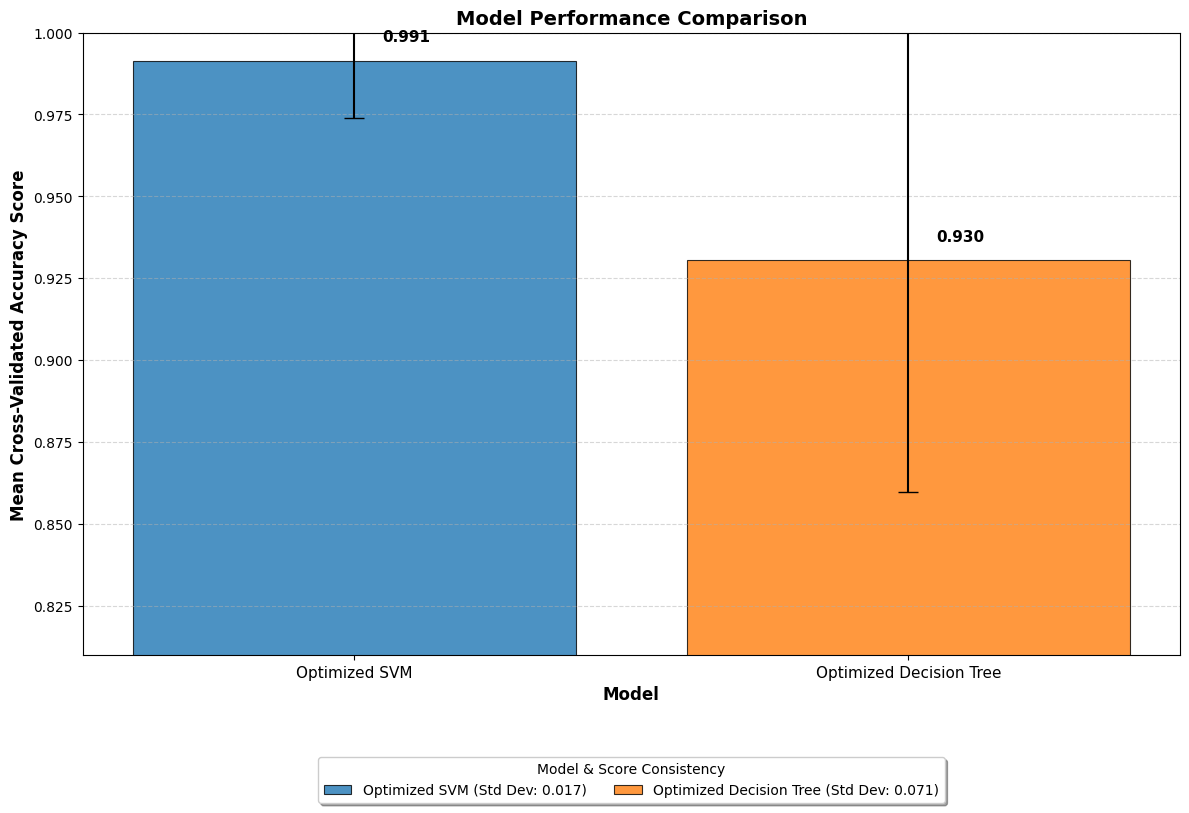

In [29]:
fig, ax = plt.subplots(figsize=(12, 8)) 

# Define distinct colors for the bars
colors = ['#1f77b4', '#ff7f0e'] 

# Create bar plot with error bars
bars = ax.bar(
    models, 
    mean_cv_scores, 
    yerr=std_devs,
    capsize=7,
    color=colors,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.8
)

# Set labels and title
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Cross-Validated Accuracy Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', # Removed the "± 1 Std Dev" from the title as it's in the legend
             fontsize=14, fontweight='bold')

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=10)

# --- Adjust label positions for right alignment and slight lift ---
label_offset_y = 0.005 # Vertical lift (raised slightly from 0.0025)
label_offset_x = 0.05  # Horizontal offset from the bar edge

# Add text labels: Positioned to the RIGHT of the bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    
    # Vertical position: Bar height + small vertical offset
    label_y_pos = yval + label_offset_y 

    # Horizontal position: Right edge of bar + horizontal offset
    label_x_pos = bar.get_x() + bar.get_width()*1/2 + label_offset_x
    
    ax.text(label_x_pos,
            label_y_pos,
            f'{yval:.3f}',
            ha="left", # KEY: Alignment is left, so the text starts at label_x_pos
            va='bottom',
            fontsize=11,
            color='black',
            fontweight='bold')

# Set y-axis limits dynamically
min_score_with_std = min([score - std for score, std in zip(mean_cv_scores, std_devs)])
y_min = max(0, min_score_with_std - 0.05) 
ax.set_ylim(y_min, 1.0) 

# Add a subtle grid
ax.grid(axis='y', linestyle='--', alpha=0.5)

# CCreate label:
legend_labels = [
    f'{models[i]} (Std Dev: {std_devs[i]:.3f})' for i in range(len(models))
]

# Adding the legend using the bar objects and custom labels
ax.legend(
    bars, 
    legend_labels,
    title='Model & Score Consistency',
    loc='center', 
    bbox_to_anchor=(0.5, -0.2), # Moved below the x-axis
    fancybox=True,
    shadow=True,
    ncol=len(models) 
)

# Increase bottom margin, making space for the legend.
plt.subplots_adjust(bottom=0.25)

plt.tight_layout() 

plt.show()